# Data preparation

In [ ]:
import pandas as pd
import json
from google.colab import userdata
from google.colab import drive

drive.mount('/content/drive')

# Load the JSON file
file_path = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/all_news.json"

# Read the JSON file
try:
    with open(file_path, 'r', encoding='utf-8') as f:
        all_news = json.load(f)
except FileNotFoundError:
    raise Exception(f"File not found: {file_path}")
except json.JSONDecodeError:
    raise Exception("Error decoding JSON. Please check the file content.")

all_news

Mounted at /content/drive


[{'date': '2010-02-02',
  'source': 'The California Air Resources Board',
  'title': 'ARB Chairman Mary Nichols issues comment on lawsuit challenging California’s LCFS',
  'second_title': None,
  'content': ' In response to a lawsuit brought by the National Petrochemical and Refiners Association, the American Truckers Association and two other organizations challenging CARB\'s Low Carbon Fuel Standard Mary Nichols, CARB chairman, issued the following statement:\n"Their actions are shameful. This is a critical tool to help us break our dependence on fossil fuels. It will protect us from volatile oil prices and provide consumers with cleaner fuels and provide the nation with greater energy security. Our analysis shows that producing alternative fuels under this standard can save consumers as much as $11 billion over the next decade, and that\'s in California alone. Instead of fighting us in court, they should be working with us to provide consumers in California and the rest of the natio

In [ ]:
# Install models
!pip install -q -U google-generativeai
!pip install openai
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 14.6 MB/s eta 0:00:00


```
prompt = [{
        "role": "system",
        "content": (
            f"You are a sustainability strategy expert working on carbon credit systems.\n"
            f"Your task is to evaluate the impact of policies or events through news articles on California's Low Carbon Fuel Standard (LCFS) carbon credit prices.\n"
            f"Think in the following steps:\n"
            f"1. **Relevance**: Articles directly impacting LCFS market dynamics will have high socre, indirect correlations with secondary effects will have low score.\n"
            f"2. **Impact**: Assess whether the policy or event described will increase, decrease, or stabilize LCFS carbon credit prices. Note that:\n"
            f"   - More credits entering the system or advanced carbon removal technology typically drive down prices.\n"
            f"   - Fewer credits or increased demand generally raise prices.\n"
            f"3. **Duration**: Consider whether the impact is short-term (weeks), medium-term (months), or long-term (years).\n"
            f"\n"
            f"Provide a continuous sentiment score between -1 and 1:\n"
            f"- -1: Strong negative long-term impact (significant price decrease).\n"
            f"- 1: Strong positive long-term impact (significant price increase).\n"
            f"\n"
            f"Output format:\n"
            f"(Score: <score>, Reason: <reason>, Duration: <short-term/medium-term/long-term>)."
        )
        },
        # Examples
        {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: 2024-02-10\n"
            f"Source: Argus Media\n"
            f"Title: 'California eyes more oilseed limits as LCFS vote nears'\n"
            f"Content: 'California regulators proposed expanding limits on the Low Carbon Fuel Standard (LCFS) credits certain oilseeds may generate while keeping the program's tougher targets and adoption schedule unchanged. The changes may result in higher prices due to reduced supply of compliance credits.'"
        )},
        {
        "role": "assistant",
        "content": (
            f"(Score: 0.6,\n"
            f"Reason: Limiting oilseed credit generation will tighten supply and drive up prices, positively impacting the LCFS price.\n"
            f"Duration: Medium-term)"
        )},
        {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: 2023-08-23\n"
            f"Source: The California Air Resources Board\n"
            f"Title: 'For first time 50% of California diesel fuel is replaced by clean fuels'\n"
            f"Content: 'California hit an important milestone in its shift away from polluting fuel sources, with clean fuels replacing over 50% of the diesel used in the state in the first quarter of 2023. California’s Low Carbon Fuel Standard (LCFS), which requires fuel producers to reduce the carbon intensity of fuel sold in the state, is largely responsible for the shift by encouraging the use and production of cleaner alternatives.'"
        )},
        {
        "role": "assistant",
        "content": (
            f"(Score: -0.8,\n"
            f"Reason: The milestone indicates a significant increase in clean fuel supply, likely lowering LCFS credit prices due to reduced demand for compliance credits.\n"
            f"Duration: Long-term)"
        )},
        {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: {news['date']},\n"
            f"Source: {news['source']},\n"
            f"Title: {news['title']},\n"
            f"Sub-title: {news.get('second_title', 'N/A')},\n"
            f"Content: {news['content']}.\n"
            f"Please analyze and provide the score, reason, and duration."
        )}]
```

# Gemini pro 1.5

## Load the API and model

In [ ]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
model = genai.GenerativeModel('gemini-pro-1.5')

In [ ]:
# Example usage
response = model.generate_content("Score from -1 (negative) to 1 (positive) about this sentence: {I am feeling not that well but still ok} and reasoning. Output using format: (Score: {}, \n Reason: {} )")
print(response.text)

Score: 0, 
Reason: The sentence expresses a neutral sentiment, indicating that the speaker is feeling neither positive nor negative.


## Generate sentimental score

In [ ]:
output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_gemini.csv"


def model_generate_content(prompt):
    response = model.generate_content(prompt)
    return response.text

results = []
count = 0

for news in all_news:
    prompt = (
              f"You are a sustainability strategy expert working on carbon credit systems.\n"
              f"Your task is to evaluate the impact of policies or events through news articles on California's Low Carbon Fuel Standard (LCFS) carbon credit prices.\n"
              f"Think in the following steps:\n"
              f"1. **Relevance**: Articles directly impacting LCFS market dynamics will have high socre, indirect correlations with secondary effects will have low score.\n"
              f"2. **Impact**: Assess whether the policy or event described will increase, decrease, or stabilize LCFS carbon credit prices. Note that:\n"
              f"   - More credits entering the system or advanced carbon removal technology typically drive down prices.\n"
              f"   - Fewer credits or increased demand generally raise prices.\n"
              f"3. **Duration**: Consider whether the impact is short-term (weeks), medium-term (months), or long-term (years).\n"
              f"\n"
              f"Provide a continuous sentiment score between -1 and 1:\n"
              f"- -1: Strong negative long-term impact (significant price decrease).\n"
              f"- 1: Strong positive long-term impact (significant price increase).\n"
              f"\n"
              f"Output format:\n"
              f"(Score: <score>, Reason: <reason>, Duration: <short-term/medium-term/long-term>)."
              f"\n"
              f"Here are some examples"
              f"Example 1:\n"
              f"Date: 2024-02-10\n"
              f"Source: Argus Media\n"
              f"Title: 'California eyes more oilseed limits as LCFS vote nears'\n"
              f"Content: 'California regulators proposed expanding limits on the Low Carbon Fuel Standard (LCFS) credits certain oilseeds may generate while keeping the program's tougher targets and adoption schedule unchanged. The changes may result in higher prices due to reduced supply of compliance credits.'"
              f"(Score: 0.6,\n"
              f"Reason: Limiting oilseed credit generation will tighten supply and drive up prices, positively impacting the LCFS price.\n"
              f"Duration: Medium-term)"
              f"Example 2:\n"
              f"Date: 2023-08-23\n"
              f"Source: The California Air Resources Board\n"
              f"Title: 'For first time 50% of California diesel fuel is replaced by clean fuels'\n"
              f"Content: 'California hit an important milestone in its shift away from polluting fuel sources, with clean fuels replacing over 50% of the diesel used in the state in the first quarter of 2023. California’s Low Carbon Fuel Standard (LCFS), which requires fuel producers to reduce the carbon intensity of fuel sold in the state, is largely responsible for the shift by encouraging the use and production of cleaner alternatives.'"
              f"(Score: -0.8,\n"
              f"Reason: The milestone indicates a significant increase in clean fuel supply, likely lowering LCFS credit prices due to reduced demand for compliance credits.\n"
              f"Duration: Long-term)"
              f"Here is the news article to evaluate:\n"
              f"Date: {news['date']},\n"
              f"Source: {news['source']},\n"
              f"Title: {news['title']},\n"
              f"Sub-title: {news.get('second_title', 'N/A')},\n"
              f"Content: {news['content']}.\n"
              f"Please analyze and provide the score, reason, and duration.")

    # Get response from the model
    response = model_generate_content(prompt)
    count += 1
    if count % 100 == 0:
      print(f"Processed promt: {count}")

    # Extract score and reason from the response
    try:
        # The response is structured as "(Score: <score>, Reason: <reason>)"
        score_start = response.find("Score: ") + len("Score: ")
        score_end = response.find(",", score_start)
        score = float(response[score_start:score_end].strip())

        reason_start = response.find("Reason: ") + len("Reason: ")
        duration_start = response.find("Duration: ") + len("Duration: ")
        duration_end = response.find(")", duration_start)

        reason = response[reason_start:response.find("\n", reason_start)].strip()
        duration = response[duration_start:duration_end].strip()
    except Exception as e:
        print(f"Error processing response: {response}. Error: {e}")
        score = None
        reason = response  # Use the whole response as the reason
        duration = None

    # Append the result
    results.append({
        "date": news['date'],
        "score": score,
        "reason": reason,
        "duration": duration
    })

# Create a DataFrame from the results
gemini_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
gemini_results.to_csv(output_file, index=False)

print(f"Results have been saved to: {output_file}")

Error processing response: (Score: N/A, Reason: No direct or indirect impact on LCFS carbon credit prices, Duration: N/A). Error: could not convert string to float: 'N/A'
Error processing response: The news article does not directly impact California's Low Carbon Fuel Standard (LCFS) carbon credit prices.
Therefore, the sentiment score is 0.. Error: could not convert string to float: "ws article does not directly impact California's Low Carbon Fuel Standard (LCFS) carbon credit prices.\nTherefore"
Error processing response: The provided article is not relevant to California's LCFS carbon credit prices. (Score: N/A, Reason: Upstream natural gas capex forecast does not directly impact LCFS carbon credit prices, Duration: N/A). Error: could not convert string to float: 'N/A'
Error processing response: Score: **0**
Reason: The article does not provide any direct or indirect information that could impact LCFS carbon credit prices.
Duration: **N/A**. Error: could not convert string to float:

# ChatGPT

## gpt-4o + o1-preview

In [ ]:
!openai migrate

Traceback (most recent call last):
  File "/usr/local/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/openai/cli/_cli.py", line 129, in main
    _main()
  File "/usr/local/lib/python3.10/dist-packages/openai/cli/_cli.py", line 179, in _main
    http_client = httpx.Client(
TypeError: Client.__init__() got an unexpected keyword argument 'proxies'


In [ ]:
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [ ]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)

stream = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-4o",
    stream=True,
)
for chunk in stream:
    print(chunk.choices[0].delta.content or "", end="")

TypeError: AsyncClient.__init__() got an unexpected keyword argument 'proxies'

## Gneration of response - 4o

In [ ]:
output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_gpt4o.csv"

# Retrieve your API key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    api_key=OPENAI_API_KEY,
)

# Mockup model generation function
def model_generate_content(prompt):
    # Replace this mockup response with the actual model call
    # This is an example response format
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=prompt
        )

    return response.choices[0].message.content

# Prepare a list to store results
results = []
count = 0

# Loop through each piece of news
for news in all_news:
    # Prepare the prompt
    prompt = [{
        "role": "system",
        "content": (
            f"You are a sustainability strategy expert working on carbon credit systems.\n"
            f"Your task is to evaluate the impact of policies or events through news articles on California's Low Carbon Fuel Standard (LCFS) carbon credit prices.\n"
            f"Think in the following steps:\n"
            f"1. **Relevance**: Articles directly impacting LCFS market dynamics will have high socre, indirect correlations with secondary effects will have low score.\n"
            f"2. **Impact**: Assess whether the policy or event described will increase, decrease, or stabilize LCFS carbon credit prices. Note that:\n"
            f"   - More credits entering the system or advanced carbon removal technology typically drive down prices.\n"
            f"   - Fewer credits or increased demand generally raise prices.\n"
            f"3. **Duration**: Consider whether the impact is short-term (weeks), medium-term (months), or long-term (years).\n"
            f"\n"
            f"Provide a continuous sentiment score between -1 and 1:\n"
            f"- -1: Strong negative long-term impact (significant price decrease).\n"
            f"- 1: Strong positive long-term impact (significant price increase).\n"
            f"\n"
            f"Output format:\n"
            f"(Score: <score>, Reason: <reason>, Duration: <short-term/medium-term/long-term>)."
        )
        },
        # Examples
        {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: 2024-02-10\n"
            f"Source: Argus Media\n"
            f"Title: 'California eyes more oilseed limits as LCFS vote nears'\n"
            f"Content: 'California regulators proposed expanding limits on the Low Carbon Fuel Standard (LCFS) credits certain oilseeds may generate while keeping the program's tougher targets and adoption schedule unchanged. The changes may result in higher prices due to reduced supply of compliance credits.'"
        )},
        {
        "role": "assistant",
        "content": (
            f"(Score: 0.6,\n"
            f"Reason: Limiting oilseed credit generation will tighten supply and drive up prices, positively impacting the LCFS price.\n"
            f"Duration: Medium-term)"
        )},
        {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: 2023-08-23\n"
            f"Source: The California Air Resources Board\n"
            f"Title: 'For first time 50% of California diesel fuel is replaced by clean fuels'\n"
            f"Content: 'California hit an important milestone in its shift away from polluting fuel sources, with clean fuels replacing over 50% of the diesel used in the state in the first quarter of 2023. California’s Low Carbon Fuel Standard (LCFS), which requires fuel producers to reduce the carbon intensity of fuel sold in the state, is largely responsible for the shift by encouraging the use and production of cleaner alternatives.'"
        )},
        {
        "role": "assistant",
        "content": (
            f"(Score: -0.8,\n"
            f"Reason: The milestone indicates a significant increase in clean fuel supply, likely lowering LCFS credit prices due to reduced demand for compliance credits.\n"
            f"Duration: Long-term)"
        )},
        {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: {news['date']},\n"
            f"Source: {news['source']},\n"
            f"Title: {news['title']},\n"
            f"Sub-title: {news.get('second_title', 'N/A')},\n"
            f"Content: {news['content']}.\n"
            f"Please analyze and provide the score, reason, and duration."
        )}]

    # Get response from the model
    response = model_generate_content(prompt)
    count += 1
    if count % 100 == 0:
      print(f"Finished promt: {count}")

    # Extract score and reason from the response
    try:
        # The response is structured as "(Score: <score>, Reason: <reason>)"
        score_start = response.find("Score: ") + len("Score: ")
        score_end = response.find(",", score_start)
        score = float(response[score_start:score_end].strip())

        reason_start = response.find("Reason: ") + len("Reason: ")
        duration_start = response.find("Duration: ") + len("Duration: ")
        duration_end = response.find(")", duration_start)

        reason = response[reason_start:response.find("\n", reason_start)].strip()
        duration = response[duration_start:duration_end].strip()
    except Exception as e:
        print(f"Error processing response: {response}. Error: {e}")
        score = None
        reason = response  # Use the whole response as the reason
        duration = None

    # Append the result
    results.append({
        "date": news['date'],
        "score": score,
        "reason": reason,
        "duration": duration
    })

# Create a DataFrame from the results
gpt4o_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
gpt4o_results.to_csv(output_file, index=False)

print(f"Results have been saved to: {output_file}")

Finished promt: 100
Finished promt: 200
Finished promt: 300
Finished promt: 400
Finished promt: 500
Finished promt: 600
Results have been saved to: /content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_gpt4o.csv


## o1-preview

In [ ]:
output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_o1-preview.csv"

# Retrieve your API key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    api_key=OPENAI_API_KEY,
)


def model_generate_content(prompt):
    response = client.chat.completions.create(
        model="o1-preview",
        messages=prompt
    )
    return response.choices[0].message.content.strip()



# Prepare a list to store results
results = []
count = 0

# Loop through each piece of news
for news in all_news:
    # Prepare the prompt
    prompt = [{
        "role": "user",
        "content": (
            f"You are a sustainability strategy expert working on carbon credit systems.\n"
            f"Your task is to evaluate the impact of policies or events through news articles on California's Low Carbon Fuel Standard (LCFS) carbon credit prices.\n"
            f"Think in the following steps:\n"
            f"1. **Relevance**: Articles directly impacting LCFS market dynamics will have high socre, indirect correlations with secondary effects will have low score.\n"
            f"2. **Impact**: Assess whether the policy or event described will increase, decrease, or stabilize LCFS carbon credit prices. Note that:\n"
            f"   - More credits entering the system or advanced carbon removal technology typically drive down prices.\n"
            f"   - Fewer credits or increased demand generally raise prices.\n"
            f"3. **Duration**: Consider whether the impact is short-term (weeks), medium-term (months), or long-term (years).\n"
            f"\n"
            f"Provide a continuous sentiment score between -1 and 1:\n"
            f"- -1: Strong negative long-term impact (significant price decrease).\n"
            f"- 1: Strong positive long-term impact (significant price increase).\n"
            f"\n"
            f"Output format:\n"
            f"(Score: <score>, Reason: <reason>, Duration: <short-term/medium-term/long-term>)."
        )
        },
        # Examples
        {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: 2024-02-10\n"
            f"Source: Argus Media\n"
            f"Title: 'California eyes more oilseed limits as LCFS vote nears'\n"
            f"Content: 'California regulators proposed expanding limits on the Low Carbon Fuel Standard (LCFS) credits certain oilseeds may generate while keeping the program's tougher targets and adoption schedule unchanged. The changes may result in higher prices due to reduced supply of compliance credits.'"
        )},
        {
        "role": "assistant",
        "content": (
            f"(Score: 0.6,\n"
            f"Reason: Limiting oilseed credit generation will tighten supply and drive up prices, positively impacting the LCFS price.\n"
            f"Duration: Medium-term)"
        )},
        {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: 2023-08-23\n"
            f"Source: The California Air Resources Board\n"
            f"Title: 'For first time 50% of California diesel fuel is replaced by clean fuels'\n"
            f"Content: 'California hit an important milestone in its shift away from polluting fuel sources, with clean fuels replacing over 50% of the diesel used in the state in the first quarter of 2023. California’s Low Carbon Fuel Standard (LCFS), which requires fuel producers to reduce the carbon intensity of fuel sold in the state, is largely responsible for the shift by encouraging the use and production of cleaner alternatives.'"
        )},
        {
        "role": "assistant",
        "content": (
            f"(Score: -0.8,\n"
            f"Reason: The milestone indicates a significant increase in clean fuel supply, likely lowering LCFS credit prices due to reduced demand for compliance credits.\n"
            f"Duration: Long-term)"
        )},
        {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: {news['date']},\n"
            f"Source: {news['source']},\n"
            f"Title: {news['title']},\n"
            f"Sub-title: {news.get('second_title', 'N/A')},\n"
            f"Content: {news['content']}.\n"
            f"Please analyze and provide the score, reason, and duration."
        )}]

    # Get response from the model
    response = model_generate_content(prompt)
    count += 1
    if count % 100 == 0:
      print(f"Finished promt: {count}")

    # Extract score and reason from the response
    try:
        # The response is structured as "(Score: <score>, Reason: <reason>)"
        score_start = response.find("Score: ") + len("Score: ")
        score_end = response.find(",", score_start)
        score = float(response[score_start:score_end].strip())

        reason_start = response.find("Reason: ") + len("Reason: ")
        duration_start = response.find("Duration: ") + len("Duration: ")
        duration_end = response.find(")", duration_start)

        reason = response[reason_start:response.find("\n", reason_start)].strip()
        duration = response[duration_start:duration_end].strip()
    except Exception as e:
        print(f"Error processing response: {response}. Error: {e}")
        score = None
        reason = response  # Use the whole response as the reason
        duration = None

    # Append the result
    results.append({
        "date": news['date'],
        "score": score,
        "reason": reason,
        "duration": duration
    })

# Create a DataFrame from the results
o1_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
o1_results.to_csv(output_file, index=False)

print(f"Results have been saved to: {output_file}")

Finished promt: 100
Finished promt: 200
Finished promt: 300
Finished promt: 400
Finished promt: 500
Finished promt: 600


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

# Anthropic Claude

In [ ]:
# Test
import anthropic
from typing import List, Dict, Any

def get_claude_response(api_key, prompt,
                       model: str = "claude-3-5-sonnet-20241022",
                       max_tokens: int = 8192) -> str:
    """
    Get a response from Claude using the Anthropic API.

    Args:
        api_key (str): Your Anthropic API key
        prompt (str): The prompt to send to Claude
        model (str): The Claude model to use
        max_tokens (int): Maximum tokens in the response

    Returns:
        str: Claude's response text

    Raises:
        anthropic.APIError: If there's an API error
        anthropic.APIConnectionError: If there's a connection error
        anthropic.AuthenticationError: If the API key is invalid
    """
    try:
        # Initialize the client
        client = anthropic.Anthropic(api_key=api_key)

        # Create the message and get response
        response = client.messages.create(
            model=model,
            max_tokens=max_tokens,
            messages=[
                {"role": "user", "content":
                 (
                "Score from -1 (negative) to 1 (positive) about this sentence: "
                "{I am feeling not that well but still ok} and reasoning. "
                "Output using format: (Score: {}, \n Reason: {} )"
            )}
            ]
        )

        # Extract the response text
        return response.content[0].text

    except (anthropic.APIError,
            anthropic.APIConnectionError,
            anthropic.AuthenticationError) as e:
        print(f"Error occurred: {str(e)}")
        raise

# Example usage
if __name__ == "__main__":
    CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')

    try:
        # Get response
        response_text = get_claude_response(
            api_key=CLAUDE_API_KEY,
            prompt="Hello, world"
        )

        # Print response
        print("Claude's response:")
        print(response_text)

    except Exception as e:
        print(f"Failed to get response: {str(e)}")

Claude's response:
(Score: -0.2, 
 Reason: The sentence contains mixed sentiment with a negative phrase "not that well" balanced by a moderately positive "still ok". The overall tone leans slightly negative because the primary health statement is negative, though it's mitigated by the acceptance of the situation.)


In [ ]:
output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_claude.csv"

# Retrieve your API key
CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')


def get_claude_response(api_key, role, prompt,
                       model: str = "claude-3-5-sonnet-20241022",
                       max_tokens: int = 8192) -> str:
  client = anthropic.Anthropic(api_key=api_key)



  response = client.messages.create(
      model=model,
      max_tokens=max_tokens,
      system=role,
      messages=prompt)

  return response.content[0].text


# Prepare a list to store results
results = []
count = 0

# Loop through each piece of news
for news in all_news:
    # Prepare the prompt
    # Correct API usage - system as a top-level parameter
    role = (
            f"You are a sustainability strategy expert working on carbon credit systems.\n"
            f"Your task is to evaluate the impact of policies or events through news articles on California's Low Carbon Fuel Standard (LCFS) carbon credit prices.\n"
            f"Think in the following steps:\n"
            f"1. **Relevance**: Articles directly impacting LCFS market dynamics will have high socre, indirect correlations with secondary effects will have low score.\n"
            f"2. **Impact**: Assess whether the policy or event described will increase, decrease, or stabilize LCFS carbon credit prices. Note that:\n"
            f"   - More credits entering the system or advanced carbon removal technology typically drive down prices.\n"
            f"   - Fewer credits or increased demand generally raise prices.\n"
            f"3. **Duration**: Consider whether the impact is short-term (weeks), medium-term (months), or long-term (years).\n"
            f"\n"
            f"Provide a continuous sentiment score between -1 and 1:\n"
            f"- -1: Strong negative long-term impact (significant price decrease).\n"
            f"- 1: Strong positive long-term impact (significant price increase).\n"
            f"\n"
            f"Output format:\n"
            f"(Score: <score>, Reason: <reason>, Duration: <short-term/medium-term/long-term>)."
        )

    # Messages with only user/assistant roles
    prompt = [
        {
          "role": "user",
          "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: 2024-02-10\n"
            f"Source: Argus Media\n"
            f"Title: 'California eyes more oilseed limits as LCFS vote nears'\n"
            f"Content: 'California regulators proposed expanding limits on the Low Carbon Fuel Standard (LCFS) credits certain oilseeds may generate while keeping the program's tougher targets and adoption schedule unchanged. The changes may result in higher prices due to reduced supply of compliance credits.'"
          )
          },
        {
          "role": "assistant",
          "content": (
            f"(Score: 0.6,\n"
            f"Reason: Limiting oilseed credit generation will tighten supply and drive up prices, positively impacting the LCFS price.\n"
            f"Duration: Medium-term)"
            )
          },
        {
          "role": "user",
          "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: 2023-08-23\n"
            f"Source: The California Air Resources Board\n"
            f"Title: 'For first time 50% of California diesel fuel is replaced by clean fuels'\n"
            f"Content: 'California hit an important milestone in its shift away from polluting fuel sources, with clean fuels replacing over 50% of the diesel used in the state in the first quarter of 2023. California’s Low Carbon Fuel Standard (LCFS), which requires fuel producers to reduce the carbon intensity of fuel sold in the state, is largely responsible for the shift by encouraging the use and production of cleaner alternatives.'"
            )
          },
    {
        "role": "assistant",
        "content": (
            f"(Score: -0.8,\n"
            f"Reason: The milestone indicates a significant increase in clean fuel supply, likely lowering LCFS credit prices due to reduced demand for compliance credits.\n"
            f"Duration: Long-term)"
        )
    },
    {
        "role": "user",
        "content": (
            f"Here is the news article to evaluate:\n"
            f"Date: {news['date']},\n"
            f"Source: {news['source']},\n"
            f"Title: {news['title']},\n"
            f"Sub-title: {news.get('second_title', 'N/A')},\n"
            f"Content: {news['content']}.\n"
            f"Please analyze and provide the score, reason, and duration."
        )
    }
    ]

    # Get response from the model
    response = get_claude_response(
            api_key=CLAUDE_API_KEY,
            role=role,
            prompt=prompt
        )

    count += 1
    if count % 100 == 0:
      print(f"Finished promt: {count}")

    # Extract score and reason from the response
    try:
        # The response is structured as "(Score: <score>, Reason: <reason>)"
        score_start = response.find("Score: ") + len("Score: ")
        score_end = response.find(",", score_start)
        score = float(response[score_start:score_end].strip())

        reason_start = response.find("Reason: ") + len("Reason: ")
        duration_start = response.find("Duration: ") + len("Duration: ")
        duration_end = response.find(")", duration_start)

        reason = response[reason_start:response.find("\n", reason_start)].strip()
        duration = response[duration_start:duration_end].strip()
    except Exception as e:
        print(f"Error processing response: {response}. Error: {e}")
        score = None
        reason = response  # Use the whole response as the reason
        duration = None

    # Append the result
    results.append({
        "date": news['date'],
        "score": score,
        "reason": reason,
        "duration": duration
    })

# Create a DataFrame from the results
claude_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
claude_results.to_csv(output_file, index=False)

print(f"Results have been saved to: {output_file}")

Finished promt: 100
Finished promt: 200
Finished promt: 300
Finished promt: 400


InternalServerError: Error code: 500 - {'type': 'error', 'error': {'type': 'api_error', 'message': 'Internal server error'}}

Finished promt: 500
Finished promt: 600
Results have been saved to: /content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_claude.csv


# Analysis

In [ ]:
gemini_score = pd.read_csv("/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_gemini.csv")
gpt_score = pd.read_csv("/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_gpt4o.csv")
gpt_score = pd.read_csv("/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_o1-preview.csv")
claude_score = pd.read_csv("/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_claude.csv")

In [ ]:
gemini_score.head()

,date,score,reason
0,2010-02-02,1.0,The news is about the California Air Resources...
1,2010-02-03,1.0,The news demonstrates that CARB fully supports...
2,2011-12-16,0.5,The news introduces some changes to California...
3,2012-04-23,1.0,The court of appeals allowing enforcement of C...
4,2015-02-20,0.6,The news reports that the Air Resources Board ...


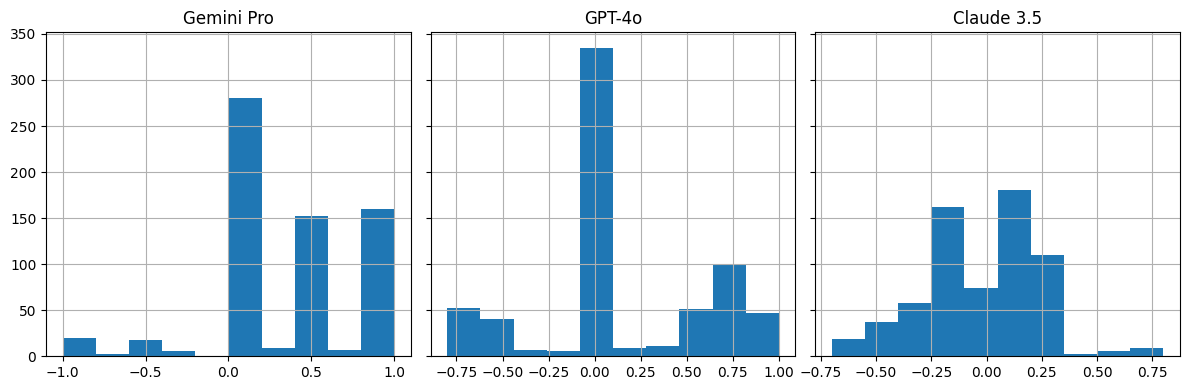

In [ ]:
# Create subplots
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

# Plot histograms for each DataFrame
gemini_score.hist('score', ax=axes[0])
gpt_score.hist('score', ax=axes[1])
claude_score.hist('score', ax=axes[2])

# Set titles
axes[0].set_title('Gemini Pro')
axes[1].set_title('GPT-4o')
axes[2].set_title('Claude 3.5')

plt.tight_layout()
plt.show()


# Llama 3

There are both Llama 3 8B and 70B models. We will attempt to use both. Using huggingface API.

Too slow here for generation, let's move to other solutions.

In [ ]:
from huggingface_hub import login

token = userdata.get('HUGGING_FACE')

login(token=token)

In [ ]:
import torch
from transformers import pipeline

model_id = "meta-llama/Llama-3.2-3B"

pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

pipe("The key to life is")


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'The key to life is to be able to make a difference in the life of others. This'}]

In [ ]:
prompt = "what is the result of 1+1, output the result in the form: Input: {}, Output: {}"
output = pipe(prompt, max_new_tokens=50, do_sample=True, temperature=0.7)

# Step 6: Print the generated text
print(output[0])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


{'generated_text': 'what is the result of 1+1, output the result in the form: Input: {}, Output: {} Input: {a: 1}, Output: {a: 2} Input: {a: 1, b: 2}, Output: {a: 3, b: 3}'}


In [ ]:
print(output[0]['generated_text'])

The key to life is to make a choice. You can choose to be a victim of the circumstances that life brings your way or you can choose to be a victor. You can choose to be a victim of your past or you can choose to be a victor over


# Exchange expect

In [ ]:
import pandas as pd
import json
from google.colab import userdata
from google.colab import drive

drive.mount('/content/drive')

# Load the JSON file
file_path = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/all_news.json"

# Read the JSON file
try:
    with open(file_path, 'r', encoding='utf-8') as f:
        all_news = json.load(f)
except FileNotFoundError:
    raise Exception(f"File not found: {file_path}")
except json.JSONDecodeError:
    raise Exception("Error decoding JSON. Please check the file content.")

all_news

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[{'date': '2010-02-02',
  'source': 'The California Air Resources Board',
  'title': 'ARB Chairman Mary Nichols issues comment on lawsuit challenging California’s LCFS',
  'second_title': None,
  'content': ' In response to a lawsuit brought by the National Petrochemical and Refiners Association, the American Truckers Association and two other organizations challenging CARB\'s Low Carbon Fuel Standard Mary Nichols, CARB chairman, issued the following statement:\n"Their actions are shameful. This is a critical tool to help us break our dependence on fossil fuels. It will protect us from volatile oil prices and provide consumers with cleaner fuels and provide the nation with greater energy security. Our analysis shows that producing alternative fuels under this standard can save consumers as much as $11 billion over the next decade, and that\'s in California alone. Instead of fighting us in court, they should be working with us to provide consumers in California and the rest of the natio

In [ ]:
path_gpt4o = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_gpt4o.csv"
path_claude = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_claude.csv"
path_gemini = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/news_scores_gemini.csv"

scores_gpt4o = pd.read_csv(path_gpt4o)
scores_claude = pd.read_csv(path_claude)
scores_gemini = pd.read_csv(path_gemini)